<a href="https://colab.research.google.com/github/dmedved90/SolarAnalytics/blob/main/Innerga_interpretacija_grafa_za_GROWATT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alat za konverziju grafova iz slika u tablice

In [ ]:
!apt-get update
!apt-get install -y tesseract-ocr
!pip install pytesseract opencv-python-headless

import cv2
import numpy as np
import pandas as pd
import pytesseract
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
from google.colab.patches import cv2_imshow
import openpyxl

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 48 not upgraded.


# 1. Određivanje plot area i margina
Ovo je potrebno jer se sa GROWATT-a ne mogu skidati podaci putem API ili log datoteka. Ideja je da se sa njihovih WEB stranica skinu grafovi proizvodnje, te se analizom slike napravi konverzija u tablicu.
Prvi korak je kalibracija - što je zapravo područje grafa u pikselima.
To će kasnije trebati za preciznije izračune.
Kod spremanja slike koristi se nazivlje Lokacija_datum_krajnje vrijeme na kojem su zabilježeni podaci_maksimalna očitana vrijednost u grafu.
OVO ZADNJE JE KLJUČNO!

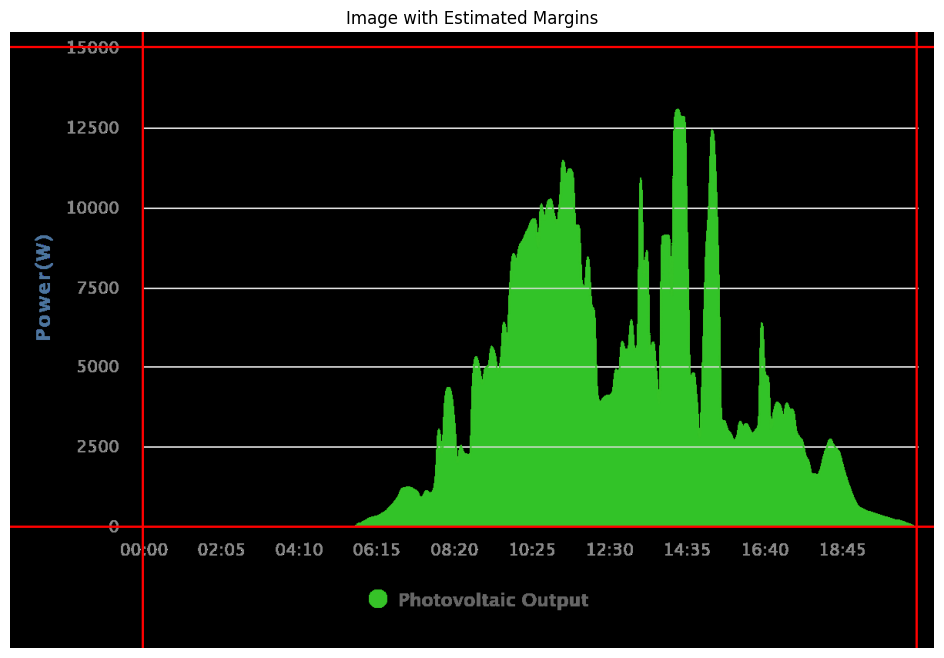

In [ ]:
# Load the image
image_path = '/content/drive/MyDrive/Tempo/Bal_29052024_2040_15000.png'  # Path to the uploaded image
image = cv2.imread(image_path)

# Define the estimated margins (adjust these values as needed)
x_plot_min, x_plot_max = 172, 1177  # example values for the x-axis margin
y_plot_min, y_plot_max = 19, 642   # example values for the y-axis margin

# Draw lines at the estimated margins
image_with_margins = image.copy()
cv2.line(image_with_margins, (x_plot_min, 0), (x_plot_min, image.shape[0]), (0, 0, 255), 2)
cv2.line(image_with_margins, (x_plot_max, 0), (x_plot_max, image.shape[0]), (0, 0, 255), 2)
cv2.line(image_with_margins, (0, y_plot_min), (image.shape[1], y_plot_min), (0, 0, 255), 2)
cv2.line(image_with_margins, (0, y_plot_max), (image.shape[1], y_plot_max), (0, 0, 255), 2)

# Display the image with the drawn lines
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(image_with_margins, cv2.COLOR_BGR2RGB))
plt.title('Image with Estimated Margins')
plt.axis('off')
plt.show()

# After visualizing, adjust the x_plot_min, x_plot_max, y_plot_min, and y_plot_max as necessary


# 2. Konverzija grafa u vrijednosti
Ova procedura vrši konverziju grafa uz pomoć CV2 u format gje je moguće napraviti edge detection i iz slike dobiti krivulju koja će služiti da daljnje korake. Testiranje pokazuje da je Canny edge algoritam detection optimalan (binarni nije dao dobre rezultate).
Prostor analize odredili smo u koraku 1.
Dobili smo 3670 data točaka na krivulji. Ta razina nam je dovoljna za daljnju analizu.

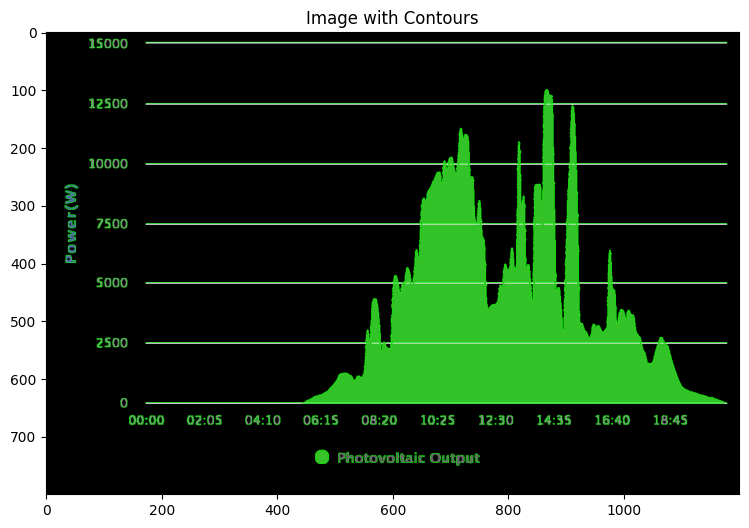

Found 3670 data points within the specified plot area.
                   time      power
394 2024-06-03 05:35:00  24.879615
393 2024-06-03 05:36:00  49.759230
395 2024-06-03 05:36:00  24.879615
392 2024-06-03 05:37:00  49.759230
1   2024-06-03 05:40:00  24.879615
..                  ...        ...
99  2024-06-03 20:33:00  74.638844
103 2024-06-03 20:35:00  49.759230
100 2024-06-03 20:36:00  24.879615
102 2024-06-03 20:36:00  49.759230
101 2024-06-03 20:37:00  24.879615

[3670 rows x 2 columns]


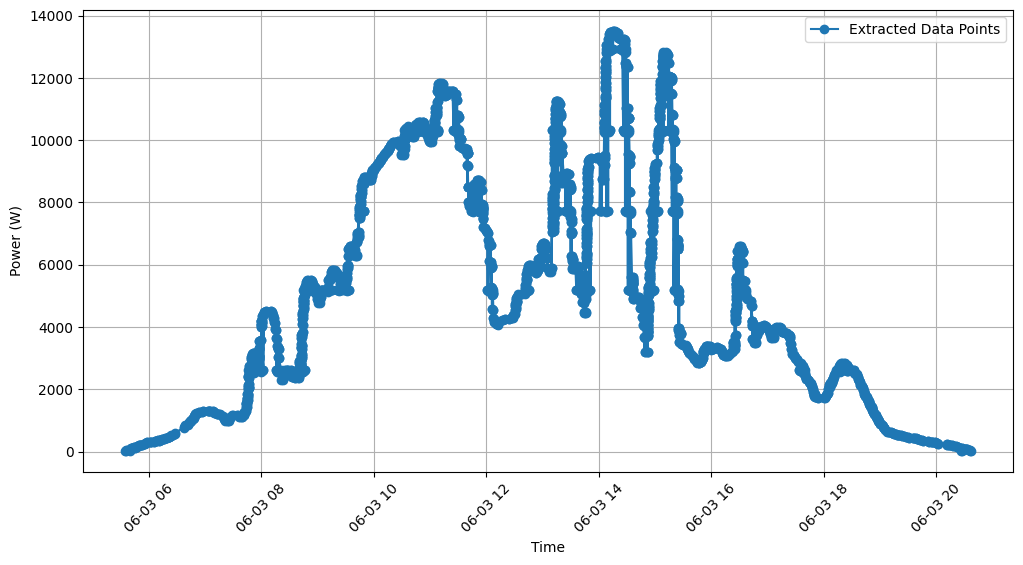

In [ ]:
# Load the image
image_path = '/content/drive/MyDrive/Tempo/Bal_29052024_2040_15000.png'
image = cv2.imread(image_path)

# Define the correct margins (adjust these values based on your visualization)
x_plot_min, x_plot_max = 175, 1177   # example values for the x-axis margin
y_plot_min, y_plot_max = 19, 642   # example values for the y-axis margin

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Canny edge detection
edges = cv2.Canny(gray, 50, 150)

# Find contours in the edges image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw all contours on the original image for debugging
image_with_contours = image.copy()
cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 1)

# Display the image with contours for debugging
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
plt.title('Image with Contours')
plt.show()

# Filter contours to keep only those within the plot area
data_points = []
for contour in contours:
    for point in contour:
        x, y = point[0]
        if x_plot_min <= x <= x_plot_max and y_plot_min <= y <= y_plot_max:
            data_points.append((x, y))

# Display the filtered data points for debugging
if not data_points:
    print("No data points found within the specified plot area.")
else:
    print(f"Found {len(data_points)} data points within the specified plot area.")

# Convert pixel coordinates to data values if data points are found
if data_points:
    # Define the range of the axes based on the chart
    x_range = pd.date_range(start='00:00', end='20:40', freq='1min')  # 1 minute sampling frequency
    y_min, y_max = 0, 15500  # example y-axis range

    # Create a DataFrame to store the extracted data points
    df_data_points = pd.DataFrame(data_points, columns=['x_pixel', 'y_pixel'])

    # Map pixel coordinates to data values
    df_data_points['time'] = df_data_points['x_pixel'].apply(
        lambda x: x_range[int((x - x_plot_min) / (x_plot_max - x_plot_min) * (len(x_range) - 1))]
    )
    df_data_points['power'] = df_data_points['y_pixel'].apply(
        lambda y: y_min + (y_plot_max - y) / (y_plot_max - y_plot_min) * (y_max - y_min)
    )

    # Sort the DataFrame by time
    df_data_points = df_data_points.sort_values(by='time')

    # Display the extracted data points in a table
    df_data_points = df_data_points[['time', 'power']]
    print(df_data_points)

    # Plotting to verify the extraction
    plt.figure(figsize=(12, 6))
    plt.plot(df_data_points['time'], df_data_points['power'], 'o-', label='Extracted Data Points')
    plt.xlabel('Time')
    plt.ylabel('Power (W)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No data points to display.")


# 3. Ekstrakcija podataka iz pojedinačne slike (uključuje datum i sampling od 1 minute)
U ovom koraku radimo mapiranje detektiranjih točaka na krivulji sa rasponima koje imamo na x i y koordinatama (OPREZ . rasponi su promjenjivi jer se mijenjaju u svakoj slici!).

Podatke čitamo sa foldera na Google diriveu (/content/drive/MyDrive/Tempo/), a rezultat zapisujemo u Excel file također na Google driveu (/content/drive/MyDrive/Innerga/Bal_solar_power_single.xlsx).
Broj podataka je reduciran na 650 parova vrijednosti.

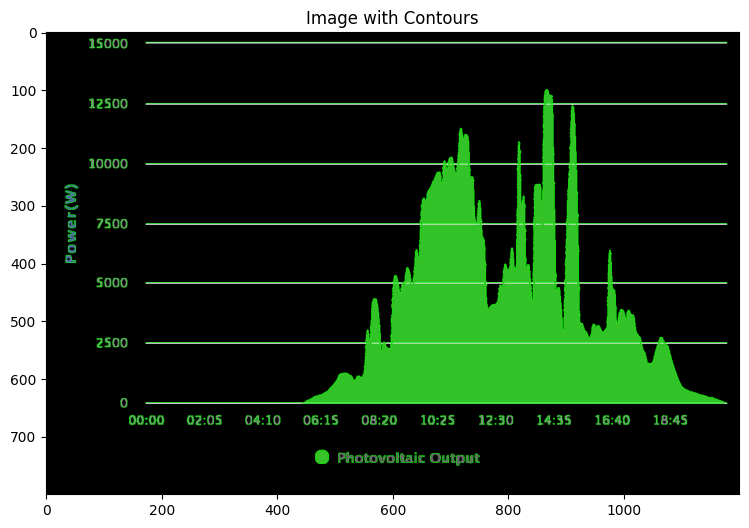

Found 3670 data points within the specified plot area.
                   time  x_pixel  y_pixel       power
0   2024-05-29 05:35:00    446.0    641.0   28.089888
1   2024-05-29 05:36:00    447.0    640.5   42.134831
2   2024-05-29 05:37:00    448.0    640.0   56.179775
3   2024-05-29 05:40:00    450.0    641.0   28.089888
4   2024-05-29 05:41:00    451.0    637.0  140.449438
..                  ...      ...      ...         ...
645 2024-05-29 20:32:00   1171.0    639.0   84.269663
646 2024-05-29 20:33:00   1172.0    639.0   84.269663
647 2024-05-29 20:35:00   1173.0    640.0   56.179775
648 2024-05-29 20:36:00   1174.0    640.5   42.134831
649 2024-05-29 20:37:00   1175.0    641.0   28.089888

[650 rows x 4 columns]
Results have been written to /content/drive/MyDrive/Innerga/Bal_solar_power_single.xlsx


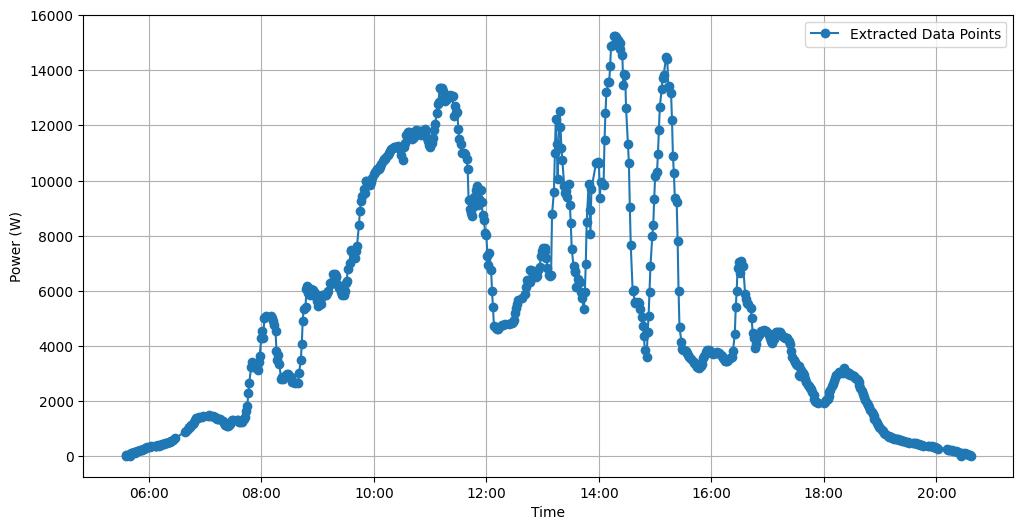

In [ ]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import openpyxl

# Load the image
image_path = '/content/drive/MyDrive/Tempo/Bal_29052024_2040_15000.png'
image = cv2.imread(image_path)

# Define the correct margins (adjust these values based on your visualization)
x_plot_min, x_plot_max = 175, 1177   # example values for the x-axis margin
y_plot_min, y_plot_max = 19, 642   # example values for the y-axis margin

# User-defined date for the image
image_date = '2024-05-29'  # example date

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Canny edge detection
edges = cv2.Canny(gray, 50, 150)

# Find contours in the edges image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw all contours on the original image for debugging
image_with_contours = image.copy()
cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 1)

# Display the image with contours for debugging
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
plt.title('Image with Contours')
plt.show()

# Filter contours to keep only those within the plot area
data_points = []
for contour in contours:
    for point in contour:
        x, y = point[0]
        if x_plot_min <= x <= x_plot_max and y_plot_min <= y <= y_plot_max:
            data_points.append((x, y))

# Display the filtered data points for debugging
if not data_points:
    print("No data points found within the specified plot area.")
else:
    print(f"Found {len(data_points)} data points within the specified plot area.")

# Convert pixel coordinates to data values if data points are found
if data_points:
    # Define the range of the axes based on the chart
    x_range = pd.date_range(start=f'{image_date} 00:00', end=f'{image_date} 20:40', freq='T')  # One-minute intervals for a 24-hour period
    y_min, y_max = 0, 17500  # example y-axis range

    # Create a DataFrame to store the extracted data points
    df_data_points = pd.DataFrame(data_points, columns=['x_pixel', 'y_pixel'])

    # Map pixel coordinates to data values
    df_data_points['time'] = df_data_points['x_pixel'].apply(
        lambda x: x_range[int((x - x_plot_min) / (x_plot_max - x_plot_min) * (len(x_range) - 1))]
    )
    df_data_points['power'] = df_data_points['y_pixel'].apply(
        lambda y: y_min + (y_plot_max - y) / (y_plot_max - y_plot_min) * (y_max - y_min)
    )

    # Sort the DataFrame by time
    df_data_points = df_data_points.sort_values(by='time')

    # Aggregate the data by averaging the power values for each minute
    df_aggregated = df_data_points.groupby('time').mean().reset_index()

    # Display the aggregated data points in a table
    print(df_aggregated)

    # Write the results to an Excel file
    output_file = '/content/drive/MyDrive/Innerga/Bal_solar_power_single.xlsx'
    df_aggregated.to_excel(output_file, index=False)
    print(f"Results have been written to {output_file}")

    # Plotting to verify the extraction
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df_aggregated['time'], df_aggregated['power'], 'o-', label='Extracted Data Points')
    ax.set_xlabel('Time')
    ax.set_ylabel('Power (W)')
    ax.legend()
    ax.grid(True)
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))  # Show only hours and minutes
    plt.show()
else:
    print("No data points to display.")

# 4. Procesiranje svih slika za tekući mjesec iz Google foldera
Automatski obrađujemo sve slike na Google folderu (VAŽNO je držati se utvrđenog nazivlja jer to određuje parametre analize!).
U ovoj verziji je y-max fiksiran na 17500 zbog usporedbi!
Nakon ovog koraka imamo cca. 17500 parova podataka za tekući mjesec,
Podaci se pohranjuju u (/content/drive/MyDrive/Innerga/Bal_solar_power_all.xlsx).

Processing filename: Bal_30062024_2055_15000.png
Match object: <re.Match object; span=(0, 27), match='Bal_30062024_2055_15000.png'>
Processing Bal_30062024_2055_15000.png for date 2024-06-30 with end time 2055


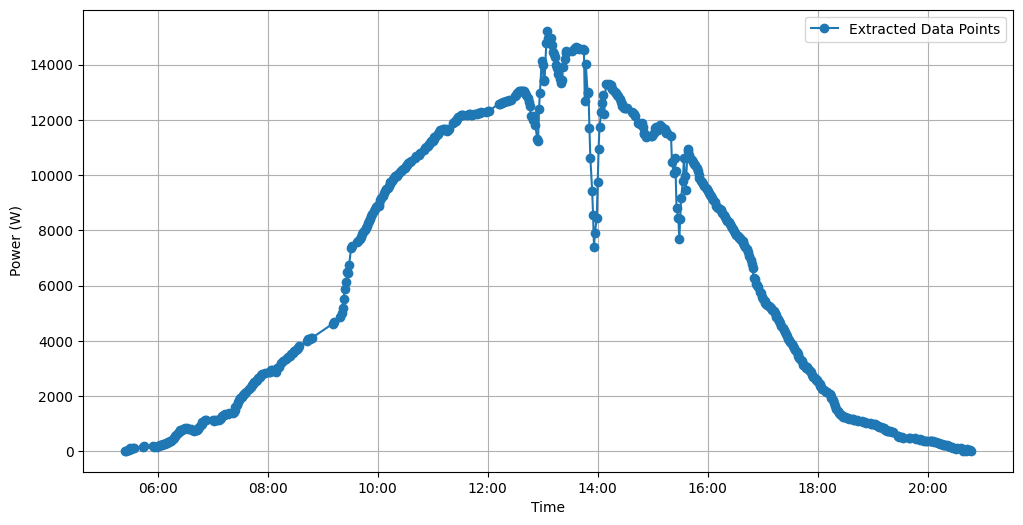

Processing filename: Bal_29062024_2050_12000.png
Match object: <re.Match object; span=(0, 27), match='Bal_29062024_2050_12000.png'>
Processing Bal_29062024_2050_12000.png for date 2024-06-29 with end time 2050
Processing filename: Bal_28062024_2050_12000.png
Match object: <re.Match object; span=(0, 27), match='Bal_28062024_2050_12000.png'>
Processing Bal_28062024_2050_12000.png for date 2024-06-28 with end time 2050
Processing filename: Bal_27062024_2050_14000.png
Match object: <re.Match object; span=(0, 27), match='Bal_27062024_2050_14000.png'>
Processing Bal_27062024_2050_14000.png for date 2024-06-27 with end time 2050
Processing filename: Bal_26062024_2100_17500.png
Match object: <re.Match object; span=(0, 27), match='Bal_26062024_2100_17500.png'>
Processing Bal_26062024_2100_17500.png for date 2024-06-26 with end time 2100
Processing filename: Bal_25062024_2055_15000.png
Match object: <re.Match object; span=(0, 27), match='Bal_25062024_2055_15000.png'>
Processing Bal_25062024_2055

In [ ]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import openpyxl
import os
import re

# Define the path to the folder containing the images
image_folder_path = '/content/drive/MyDrive/Tempo'  # Adjust the path to your folder

# Define the correct margins (adjust these values based on your visualization)
x_plot_min, x_plot_max = 175, 1177   # example values for the x-axis margin
y_plot_min, y_plot_max = 19, 642   # example values for the y-axis margin

# Initialize a DataFrame to store all the results
all_data = pd.DataFrame()

# Process each image in the folder
for filename in os.listdir(image_folder_path):
    if filename.endswith('.png'):
        # Extract date and end time from the filename
        print(f"Processing filename: {filename}")
        #match = re.match(r'Bal_(\d{2})(\d{2})(\d{4})_(\d{2})(\d{2}).png', filename)
        match = re.match(r'Bal_(\d{2})(\d{2})(\d{4})_(\d{4})_(\d+).png', filename)
        # Print match object for debugging
        print(f"Match object: {match}")

        if match:
            day, month, year, end_time, y_max = match.groups()
            # y_max = int(y_max)  # Convert y_max to integer
            image_date = f'{year}-{month}-{day}'
            # end_time = f'{hour}:{minute}'
            print(f'Processing {filename} for date {image_date} with end time {end_time}')

            # Load the image
            image_path = os.path.join(image_folder_path, filename)
            image = cv2.imread(image_path)

            # Convert the image to grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Apply Canny edge detection
            edges = cv2.Canny(gray, 50, 150)

            # Find contours in the edges image
            contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Filter contours to keep only those within the plot area
            data_points = []
            for contour in contours:
                for point in contour:
                    x, y = point[0]
                    if x_plot_min <= x <= x_plot_max and y_plot_min <= y <= y_plot_max:
                        data_points.append((x, y))

            # Convert pixel coordinates to data values if data points are found
            if data_points:
                # Define the range of the axes based on the chart
                x_range = pd.date_range(start=f'{image_date} 00:00', end=f'{image_date} {end_time}', freq='T')  # One-minute intervals for a 24-hour period
                y_min, y_max = 0, 17500  # example y-axis range

                # Create a DataFrame to store the extracted data points
                df_data_points = pd.DataFrame(data_points, columns=['x_pixel', 'y_pixel'])

                # Map pixel coordinates to data values
                df_data_points['time'] = df_data_points['x_pixel'].apply(
                    lambda x: x_range[int((x - x_plot_min) / (x_plot_max - x_plot_min) * (len(x_range) - 1))]
                )
                df_data_points['power'] = df_data_points['y_pixel'].apply(
                    lambda y: y_min + (y_plot_max - y) / (y_plot_max - y_plot_min) * (y_max - y_min)
                )

                # Sort the DataFrame by time
                df_data_points = df_data_points.sort_values(by='time')

                # Aggregate the data by averaging the power values for each minute
                df_aggregated = df_data_points.groupby('time').mean().reset_index()

                # Add date information to the aggregated data
                df_aggregated['date'] = image_date

                # Append the results to the overall DataFrame
                all_data = pd.concat([all_data, df_aggregated], ignore_index=True)

                # Plotting to verify the extraction for the first image
                if all_data.shape[0] == df_aggregated.shape[0]:
                    fig, ax = plt.subplots(figsize=(12, 6))
                    ax.plot(df_aggregated['time'], df_aggregated['power'], 'o-', label='Extracted Data Points')
                    ax.set_xlabel('Time')
                    ax.set_ylabel('Power (W)')
                    ax.legend()
                    ax.grid(True)
                    ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))  # Show only hours and minutes
                    plt.show()


# Sort the overall DataFrame by date and time before saving to Excel
all_data['datetime'] = pd.to_datetime(all_data['date'] + ' ' + all_data['time'].dt.strftime('%H:%M:%S'))
all_data = all_data.sort_values(by='datetime').drop(columns=['datetime'])

# Display the aggregated data points in a table
print(all_data)

# Write the results to an Excel file
output_file = '/content/drive/MyDrive/Innerga/Bal_solar_power_all.xlsx'
all_data.to_excel(output_file, index=False)
print(f"Results have been written to {output_file}")


# 5. Identifikacija razlika u ekstrahiranim podacima i sumarnim podacima sa GROWATT WEB stranice
Postoji neka razlika u podacima (oko 10%) kada se gledaju sumarno na GROWATT web stranicama u odnosu na ovo što smo dobili nakon konverzije. To je normalno jer smo ekstrahirali podatke iz slike. Treba vidjeti kako minimizirati grešku.
Rezultat analize se upisuje u ('/content/drive/MyDrive/Innerga/Bal_solar_power_comparison.xlsx').

Processing filename: Bal_30062024_2055_15000.png
Match object: <re.Match object; span=(0, 27), match='Bal_30062024_2055_15000.png'>
Matched date: 2024-06-30, end time: 20:55, y_max: 15000


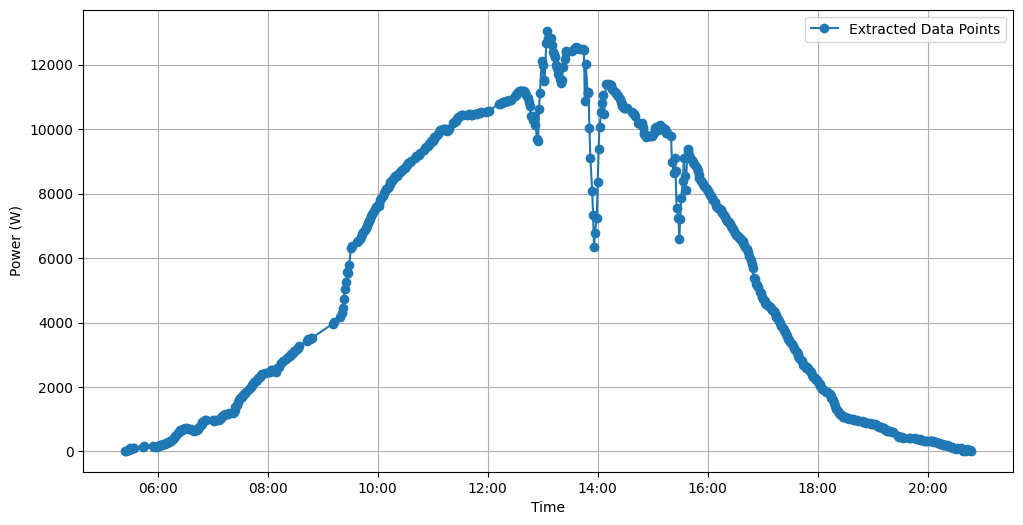

Processing filename: Bal_29062024_2050_12000.png
Match object: <re.Match object; span=(0, 27), match='Bal_29062024_2050_12000.png'>
Matched date: 2024-06-29, end time: 20:50, y_max: 12000
Processing filename: Bal_28062024_2050_12000.png
Match object: <re.Match object; span=(0, 27), match='Bal_28062024_2050_12000.png'>
Matched date: 2024-06-28, end time: 20:50, y_max: 12000
Processing filename: Bal_27062024_2050_14000.png
Match object: <re.Match object; span=(0, 27), match='Bal_27062024_2050_14000.png'>
Matched date: 2024-06-27, end time: 20:50, y_max: 14000
Processing filename: Bal_26062024_2100_17500.png
Match object: <re.Match object; span=(0, 27), match='Bal_26062024_2100_17500.png'>
Matched date: 2024-06-26, end time: 21:00, y_max: 17500
Processing filename: Bal_25062024_2055_15000.png
Match object: <re.Match object; span=(0, 27), match='Bal_25062024_2055_15000.png'>
Matched date: 2024-06-25, end time: 20:55, y_max: 15000
Processing filename: Bal_24062024_2055_15000.png
Match objec

,date,reference_power,calculated_power,discrepancy
0,2024-06-01,96.0,5.307757,-90.692243
1,2024-06-02,53.8,41.114125,-12.685875
2,2024-06-03,74.8,66.259934,-8.540066
3,2024-06-04,56.4,51.797371,-4.602629
4,2024-06-05,50.7,43.500988,-7.199012
5,2024-06-06,88.6,56.523080,-32.076920
6,2024-06-07,79.5,63.514304,-15.985696
7,2024-06-08,69.7,52.452712,-17.247288
8,2024-06-09,62.3,50.654835,-11.645165
9,2024-06-10,0.0,0.023141,0.023141


In [ ]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import openpyxl
import os
import re

# Define the path to the folder containing the images
image_folder_path = '/content/drive/MyDrive/Tempo'  # Adjust the path to your folder

# Define the correct margins (adjust these values based on your visualization)
x_plot_min, x_plot_max = 175, 1177   # example values for the x-axis margin
y_plot_min, y_plot_max = 19, 642   # example values for the y-axis margin

# Initialize a DataFrame to store all the results
all_data = pd.DataFrame()

# Process each image in the folder
for filename in os.listdir(image_folder_path):
    if filename.endswith('.png'):
        # Print the filename being processed
        print(f"Processing filename: {filename}")

        # Extract date and end time from the filename
        # match = re.match(r'Bal_(\d{2})(\d{2})(\d{4})_(\d{2})(\d{2})_(\d+).png', filename)
        match = re.match(r'Bal_(\d{2})(\d{2})(\d{4})_(\d{4})_(\d+).png', filename)

        # Print match object for debugging
        print(f"Match object: {match}")

        if match:
            day, month, year, end_time, y_max = match.groups()
            y_max = int(y_max)  # Convert y_max to integer
            image_date = f'{year}-{month}-{day}'
            hour, minute = end_time[:2], end_time[2:]
            end_time = f'{hour}:{minute}'
            print(f'Matched date: {image_date}, end time: {end_time}, y_max: {y_max}')

            # Load the image
            image_path = os.path.join(image_folder_path, filename)
            image = cv2.imread(image_path)

            # Convert the image to grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Apply Canny edge detection
            edges = cv2.Canny(gray, 50, 150) # Adjust thresholds (e.g., 30 and 100) for better noise reduction

            # Find contours in the edges image
            contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Filter contours to keep only those within the plot area
            data_points = []
            for contour in contours:
                for point in contour:
                    x, y = point[0]
                    if x_plot_min <= x <= x_plot_max and y_plot_min <= y <= y_plot_max:
                        data_points.append((x, y))

            # Convert pixel coordinates to data values if data points are found
            if data_points:
                # Define the range of the axes based on the chart
                x_range = pd.date_range(start=f'{image_date} 00:00', end=f'{image_date} {end_time}', freq='T')  # One-minute intervals for a 24-hour period

                # Create a DataFrame to store the extracted data points
                df_data_points = pd.DataFrame(data_points, columns=['x_pixel', 'y_pixel'])

                # Map pixel coordinates to data values
                df_data_points['time'] = df_data_points['x_pixel'].apply(
                    lambda x: x_range[int((x - x_plot_min) / (x_plot_max - x_plot_min) * (len(x_range) - 1))]
                )
                df_data_points['power'] = df_data_points['y_pixel'].apply(
                    # lambda y: y_min + (y_plot_max - y) / (y_plot_max - y_plot_min) * (y_max - y_min)
                    lambda y: y_max * (1 - (y - y_plot_min) / (y_plot_max - y_plot_min))
                )

                # Sort the DataFrame by time
                df_data_points = df_data_points.sort_values(by='time')

                # Aggregate the data by averaging the power values for each minute
                df_aggregated = df_data_points.groupby('time').mean().reset_index()

                # Add date information to the aggregated data
                df_aggregated['date'] = image_date

                # Append the results to the overall DataFrame
                all_data = pd.concat([all_data, df_aggregated], ignore_index=True)

                # Plotting to verify the extraction for the first image
                if all_data.shape[0] == df_aggregated.shape[0]:
                    fig, ax = plt.subplots(figsize=(12, 6))
                    ax.plot(df_aggregated['time'], df_aggregated['power'], 'o-', label='Extracted Data Points')
                    ax.set_xlabel('Time')
                    ax.set_ylabel('Power (W)')
                    ax.legend()
                    ax.grid(True)
                    ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))  # Show only hours and minutes
                    plt.show()
        else:
            print(f"No match found for filename: {filename}")

# Calculate daily totals
all_data['datetime'] = pd.to_datetime(all_data['date'] + ' ' + all_data['time'].dt.strftime('%H:%M:%S'))
all_data['date'] = all_data['datetime'].dt.date
all_data['power_kWh'] = all_data['power'] / 1000 / 60  # Convert power from watts to kWh for one-minute intervals
daily_totals = all_data.groupby('date')['power_kWh'].sum().reset_index()

# Reference data for comparison
reference_data = {
    'date': pd.date_range(start='2024-06-01', end='2024-06-30', freq='D'),
    'reference_power': [96.0, 53.8, 74.8, 56.4, 50.7, 88.6, 79.5, 69.7, 62.3, 0, 0, 0, 0, 31.9, 76.5, 83.0, 76.2, 81.2, 75.0,	68.1,	45.3,	83.7,	73.9,	66.4,	73.1,	69.3,	62.1,	80.5,	75.0,	79.6]
}
reference_df = pd.DataFrame(reference_data)

# Ensure the date columns are of the same type
daily_totals['date'] = pd.to_datetime(daily_totals['date'])
reference_df['date'] = pd.to_datetime(reference_df['date'])

# Merge the calculated totals with the reference data
comparison_df = pd.merge(reference_df, daily_totals, how='left', left_on='date', right_on='date')
comparison_df = comparison_df.rename(columns={'power_kWh': 'calculated_power'})

# Calculate discrepancies
comparison_df['discrepancy'] = comparison_df['calculated_power'] - comparison_df['reference_power']

# Write the results to an Excel file
output_file = '/content/drive/MyDrive/Innerga/Bal_solar_power_comparison.xlsx'
comparison_df.to_excel(output_file, index=False)
print(f"Comparison results have been written to {output_file}")

# Display the comparison DataFrame
comparison_df


# 6. Poboljšana verzija analize (treba ovo nastaviti)
Pokušaj rješavanja problema sa razlikama u vrijednostima proizvedene energije. Za usporedbu dodajemo realne podatke sa GROWATT WEB stranice.

Ova verzije je malo poboljšanje još uvijek na neke dane imamo velike razlike!

Processing filename: Bal_30062024_2055_15000.png
Match object: <re.Match object; span=(0, 27), match='Bal_30062024_2055_15000.png'>
Matched date: 2024-06-30, end time: 20:55, y_max: 15000


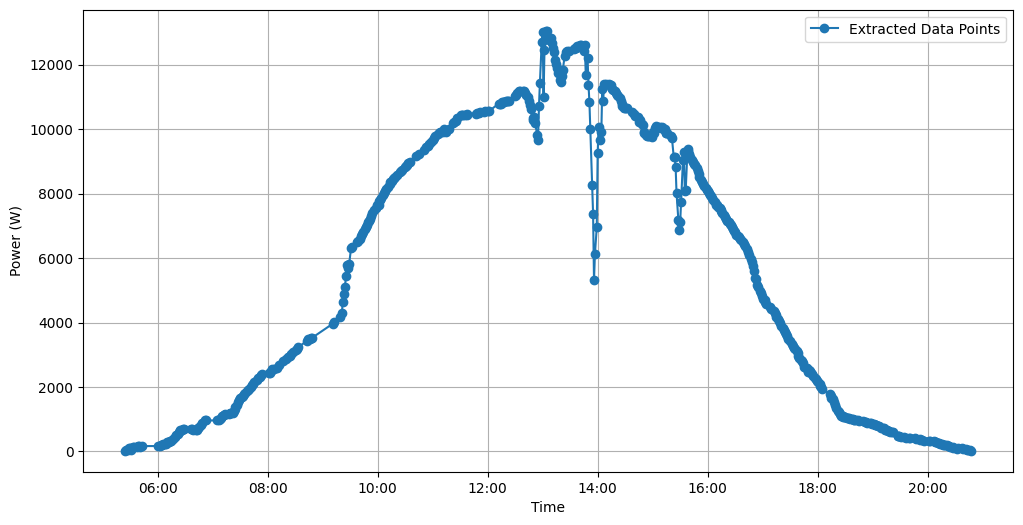

Processing filename: Bal_29062024_2050_12000.png
Match object: <re.Match object; span=(0, 27), match='Bal_29062024_2050_12000.png'>
Matched date: 2024-06-29, end time: 20:50, y_max: 12000
Processing filename: Bal_28062024_2050_12000.png
Match object: <re.Match object; span=(0, 27), match='Bal_28062024_2050_12000.png'>
Matched date: 2024-06-28, end time: 20:50, y_max: 12000
Processing filename: Bal_27062024_2050_14000.png
Match object: <re.Match object; span=(0, 27), match='Bal_27062024_2050_14000.png'>
Matched date: 2024-06-27, end time: 20:50, y_max: 14000
Processing filename: Bal_26062024_2100_17500.png
Match object: <re.Match object; span=(0, 27), match='Bal_26062024_2100_17500.png'>
Matched date: 2024-06-26, end time: 21:00, y_max: 17500
Processing filename: Bal_25062024_2055_15000.png
Match object: <re.Match object; span=(0, 27), match='Bal_25062024_2055_15000.png'>
Matched date: 2024-06-25, end time: 20:55, y_max: 15000
Processing filename: Bal_24062024_2055_15000.png
Match objec

,date,reference_power,calculated_power,discrepancy
0,2024-06-01,96.0,4.891838,-91.108162
1,2024-06-02,53.8,39.046718,-14.753282
2,2024-06-03,74.8,65.951221,-8.848779
3,2024-06-04,56.4,50.757153,-5.642847
4,2024-06-05,50.7,43.549482,-7.150518
5,2024-06-06,88.6,48.463813,-40.136187
6,2024-06-07,79.5,59.561651,-19.938349
7,2024-06-08,69.7,49.722996,-19.977004
8,2024-06-09,62.3,50.237242,-12.062758
9,2024-06-10,0.0,0.024392,0.024392


In [ ]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import openpyxl
import os
import re

# Define the path to the folder containing the images
image_folder_path = '/content/drive/MyDrive/Tempo'  # Adjust the path to your folder

# Define the correct margins (adjust these values based on your visualization)
x_plot_min, x_plot_max = 175, 1177   # example values for the x-axis margin
y_plot_min, y_plot_max = 19, 642   # example values for the y-axis margin

# Initialize a DataFrame to store all the results
all_data = pd.DataFrame()

# Process each image in the folder
for filename in os.listdir(image_folder_path):
    if filename.endswith('.png'):
        # Print the filename being processed
        print(f"Processing filename: {filename}")

        # Extract date, end time, and y_max from the filename
        match = re.match(r'Bal_(\d{2})(\d{2})(\d{4})_(\d{4})_(\d+).png', filename)

        # Print match object for debugging
        print(f"Match object: {match}")

        if match:
            day, month, year, end_time, y_max = match.groups()
            y_max = int(y_max)  # Convert y_max to integer
            image_date = f'{year}-{month}-{day}'
            hour, minute = end_time[:2], end_time[2:]
            end_time = f'{hour}:{minute}'
            print(f'Matched date: {image_date}, end time: {end_time}, y_max: {y_max}')

            # Load the image
            image_path = os.path.join(image_folder_path, filename)
            image = cv2.imread(image_path)

            # Convert the image to grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Apply Gaussian Blur to reduce noise
            blurred = cv2.GaussianBlur(gray, (5, 5), 0)

            # Apply Canny edge detection with adjusted thresholds
            edges = cv2.Canny(blurred, 50, 150)

            # Find contours in the edges image
            contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Filter contours to keep only those within the plot area
            data_points = []
            for contour in contours:
                for point in contour:
                    x, y = point[0]
                    if x_plot_min <= x <= x_plot_max and y_plot_min <= y <= y_plot_max:
                        data_points.append((x, y))

            # Print extracted data points for debugging
            # print(f"Extracted {len(data_points)} data points from {filename}")


            # Convert pixel coordinates to data values if data points are found
            if data_points:
                # Define the range of the axes based on the chart
                x_range = pd.date_range(start=f'{image_date} 00:00', end=f'{image_date} {end_time}', freq='T')  # One-minute intervals for a 24-hour period

                # Create a DataFrame to store the extracted data points
                df_data_points = pd.DataFrame(data_points, columns=['x_pixel', 'y_pixel'])

                # Map pixel coordinates to data values
                df_data_points['time'] = df_data_points['x_pixel'].apply(
                    lambda x: x_range[int((x - x_plot_min) / (x_plot_max - x_plot_min) * (len(x_range) - 1))]
                )
                df_data_points['power'] = df_data_points['y_pixel'].apply(
                    lambda y: y_max * (1 - (y - y_plot_min) / (y_plot_max - y_plot_min))
                )

                # Print a sample of the converted data points for debugging
                # print(df_data_points.head())

                # Sort the DataFrame by time
                df_data_points = df_data_points.sort_values(by='time')

                # Aggregate the data by averaging the power values for each minute
                df_aggregated = df_data_points.groupby('time').mean().reset_index()

                # Add date information to the aggregated data
                df_aggregated['date'] = image_date

                # Append the results to the overall DataFrame
                all_data = pd.concat([all_data, df_aggregated], ignore_index=True)

                # Plotting to verify the extraction for the first image
                if all_data.shape[0] == df_aggregated.shape[0]:
                    fig, ax = plt.subplots(figsize=(12, 6))
                    ax.plot(df_aggregated['time'], df_aggregated['power'], 'o-', label='Extracted Data Points')
                    ax.set_xlabel('Time')
                    ax.set_ylabel('Power (W)')
                    ax.legend()
                    ax.grid(True)
                    ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))  # Show only hours and minutes
                    plt.show()
        else:
            print(f"No match found for filename: {filename}")

# Calculate daily totals in kWh
all_data['datetime'] = pd.to_datetime(all_data['date'] + ' ' + all_data['time'].dt.strftime('%H:%M:%S'))
all_data['date'] = all_data['datetime'].dt.date
all_data['power_kWh'] = all_data['power'] / 1000 / 60  # Convert power from watts to kWh for one-minute intervals
daily_totals = all_data.groupby('date')['power_kWh'].sum().reset_index()

# Reference data for comparison
reference_data = {
    'date': pd.date_range(start='2024-06-01', end='2024-06-30', freq='D'),
    # 'reference_power': [0, 0, 43.2, 42, 115.2, 69.9, 26.6, 57, 85.5, 88.6, 90.2, 81.9, 42.6, 54.9, 52.0, 41.5, 91.5, 87.4, 75.7, 44.8, 12.2, 84.0, 85.4, 75.7, 85.1, 77.2, 81.0, 83.3, 59.0, 65.5, 46.4]
    'reference_power': [96.0, 53.8, 74.8, 56.4, 50.7, 88.6, 79.5, 69.7, 62.3, 0, 0, 0, 0, 31.9, 76.5, 83.0, 76.2, 81.2, 75.0,	68.1,	45.3,	83.7,	73.9,	66.4,	73.1,	69.3,	62.1,	80.5,	75.0,	79.6]
}
reference_df = pd.DataFrame(reference_data)

# Ensure the date columns are of the same type
daily_totals['date'] = pd.to_datetime(daily_totals['date'])
reference_df['date'] = pd.to_datetime(reference_df['date'])

# Merge the calculated totals with the reference data
comparison_df = pd.merge(reference_df, daily_totals, how='left', left_on='date', right_on='date')
comparison_df = comparison_df.rename(columns={'power_kWh': 'calculated_power'})

# Calculate discrepancies
comparison_df['discrepancy'] = comparison_df['calculated_power'] - comparison_df['reference_power']

# Write the results to an Excel file
output_file = '/content/drive/MyDrive/Innerga/Bal_solar_power_comparison_v2.xlsx'
comparison_df.to_excel(output_file, index=False)
print(f"Comparison results have been written to {output_file}")

# Display the comparison DataFrame
comparison_df
